# Distance between volcanoes and trench 

In this notebook we take a look at the correlation between the distances between the volcanoes and the obliquities of the subduction. First, we have to calculate the distances between the volcanoes and their nearest point on the trench.

In [1]:
%matplotlib inline

# importing the needed libraries/modules

from scipy import spatial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely.geometry as geo
import geopy.distance

In [2]:
# Importing our files from the previous sessions

trench = pd.read_pickle("./data/Obliquity")
volcanoes = pd.read_pickle("./data/gdf_volcanoes")
america = gpd.read_file("./data/Continent/SouthAmerica.shp")

In [3]:
# We want to use the absolute values of the angles for our calculations

trench["Obliquity"] = abs(trench["Obliquity"])

In [4]:
# Using the same method as previous sessions to create pairs of 
# volcanoes - locations on the trench

lon = trench.values[:,0]
lat = trench.values[:,1]

trench_coordinates = np.c_[lon, lat] # creates ndarray of the trench coordinates

tree = spatial.KDTree(trench_coordinates) # creates KDTree

nodes = np.c_[volcanoes["Longitude"], volcanoes["Latitude"]] # ndarray of volcano coordinates

list = [] # stores the point on the trench that is the closest to the volcano

for node in nodes:
    tree = spatial.KDTree(trench_coordinates)
    tree.query(node)[1]
    list.append(tree.query(node)[1])

In [5]:
# Creates lists for the distances between the volcanoes and their nearest points 
# and their respective coordinates and obliquities

distances = []
latitudes = []
longitudes = []
obliquities = []

lon_vol = []
lat_vol = []

for lon, lat, i in zip(volcanoes["Longitude"], volcanoes["Latitude"], list):
    lon_t = trench["Longitude"].iloc[i]
    lat_t = trench["Latitude"].iloc[i]
    coords_t = (lon_t, lat_t)
    coords_vol = (lon, lat)
    distances.append(geopy.distance.distance(coords_t, coords_vol).km)
    
    lon_vol.append(lon)
    lat_vol.append(lat)
    longitudes.append(trench["Longitude"].iloc[i])
    latitudes.append(trench["Latitude"].iloc[i])
    obliquities.append(trench["Obliquity"].iloc[i])

In [6]:
# Create a new dataframe for the trench

newtrench = pd.DataFrame({'Longitude':longitudes, 
                   'Latitude':latitudes,
                   'Distances':distances,
                   'Obliquity':obliquities,
                   'lon_vol': lon_vol,
                   'lat_vol':lat_vol })

In [7]:
# Save the dataframe to pickle

newtrench.to_pickle('./data/trenchvolcanoes')

In [8]:
# Mask obliquities that have an erro
trench = trench[trench.Obliquity < 90]
newtrench = newtrench[newtrench.Obliquity < 90]

In [9]:
# Create GeoDataFrame for the new trench

gdf_trench = gpd.GeoDataFrame(newtrench, 
                            geometry = [geo.Point(x,y) for x,y in zip(newtrench.Longitude, newtrench.Latitude)])

In [10]:
# Creates the GeoDataFrames
# 1 is for the Northern Volcanic Zone
# 2 is for the Central Volcanic Zone
# 3 is for the Southern Volcanic Zone

gdf_trench1 = gdf_trench.loc[(gdf_trench['Latitude']< 6) & (gdf_trench['Latitude']>-3)]

gdf_trench2 = gdf_trench.loc[(gdf_trench['Latitude']<-15) & (gdf_trench['Latitude']>-28)]

gdf_trench3 = gdf_trench.loc[(gdf_trench['Latitude']<-32) & (gdf_trench['Latitude']>-45)]

In [11]:
# Creates GeoDataFrame for the volcanoes

gdf_volcanoes = gpd.GeoDataFrame(volcanoes, geometry = [geo.Point(x,y) for x,y in zip(volcanoes.Longitude, volcanoes.Latitude)])

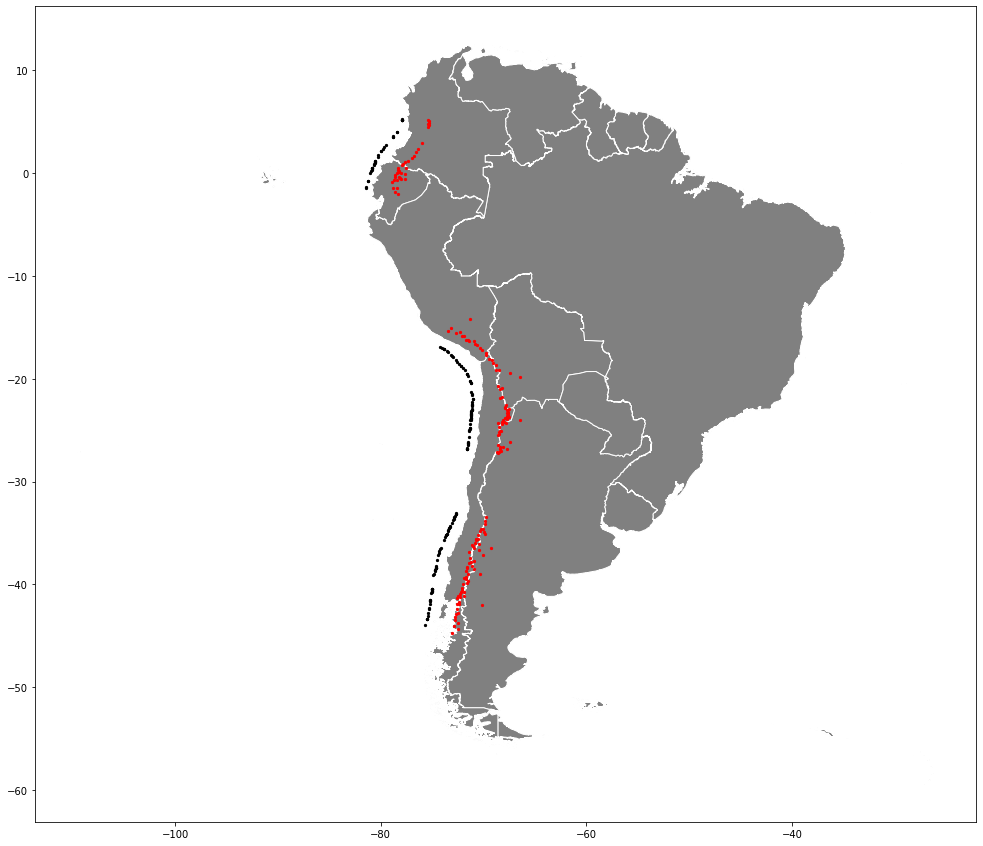

In [13]:
# Plot our volcanoes and our trench

fig, ax = plt.subplots(figsize=(30,15))
ax.set_aspect('equal')

america.plot(ax=ax, color='grey', edgecolor='white')
gdf_volcanoes.plot(ax=ax, color = "red", legend=True, markersize = 5 )
#depth_contour.plot(ax=ax, column="DEPTH", cmap=plt.cm.get_cmap('Spectral_r', 12), legend=True)
gdf_trench.plot(ax=ax,color = "black", legend =True, markersize = 5 )

For our Linear Regression, we want to remove the obliquities that are below 20° because we are not expecting strain partitioning with obliquities below 20°

In [14]:
# Filter out obliquities that are smaller than 20°

newtrench = newtrench[newtrench["Obliquity"]>20]

trench2 = gdf_trench2[gdf_trench2["Obliquity"]>20]
trench1 = gdf_trench1[gdf_trench1["Obliquity"]>20]
trench3 = gdf_trench3[gdf_trench3["Obliquity"]>20]

In [15]:
# Polynomial Regression and R-Squared calculator

def polyfit(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot

    return results['determination']

In [16]:
# Import libraries for our linear regression model
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from scipy.stats import linregress
import scipy

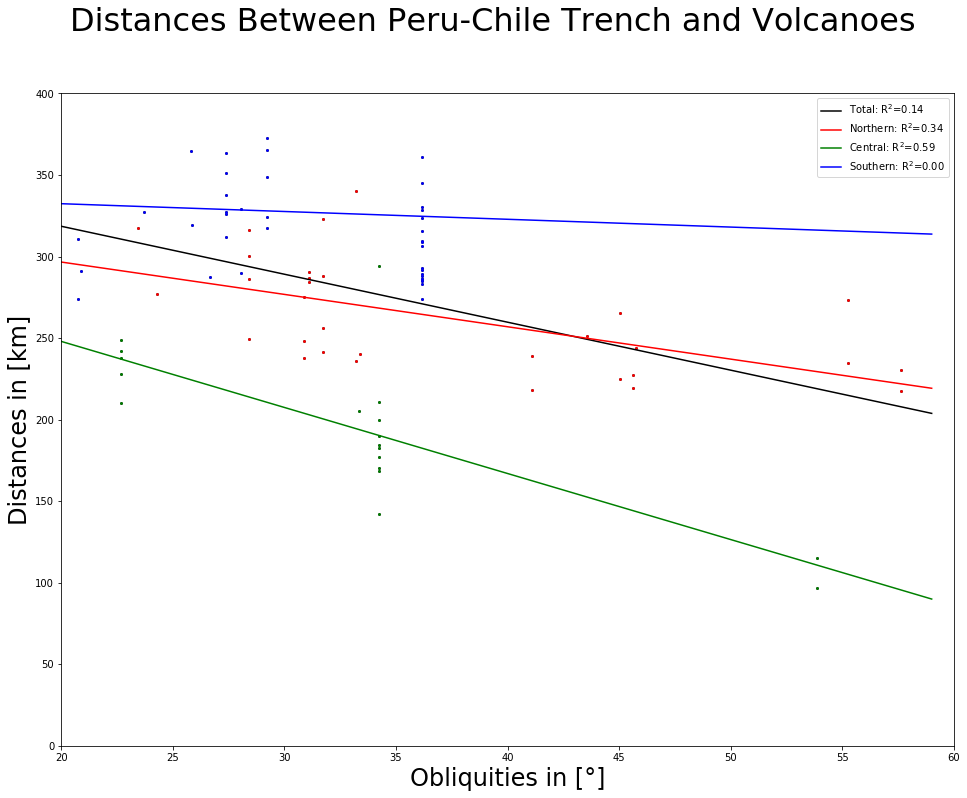

In [17]:
# Assigning x and y 

x = newtrench["Obliquity"]
y = newtrench["Distances"]

# Calculating slope, intercept, r, p and standard error with scipy.stats.linregress

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)


x1 = trench1["Obliquity"]
y1 = trench1["Distances"]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x1, y1)


x2 = trench2["Obliquity"]
y2 = trench2["Distances"]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x2, y2)


x3 = trench3["Obliquity"]
y3 = trench3["Distances"]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x3, y3)


fig, ax = plt.subplots(figsize=(16,12))

# Creating our regression models with sklearn's make_pipeline

model = make_pipeline(PolynomialFeatures(1), LinearRegression())
model.fit(np.array(x).reshape(-1, 1), y)

model1 = make_pipeline(PolynomialFeatures(1), LinearRegression())
model1.fit(np.array(x1).reshape(-1, 1), y1)

model2 = make_pipeline(PolynomialFeatures(1), LinearRegression())
model2.fit(np.array(x2).reshape(-1, 1), y2)

model3 = make_pipeline(PolynomialFeatures(1), LinearRegression())
model3.fit(np.array(x3).reshape(-1, 1), y3)



x_reg = np.arange(60) # Creating an array for the interval of our obliquities 
y_reg = model.predict(x_reg.reshape(-1, 1)) # Calculates predicted y-values

x_reg1 = np.arange(60)
y_reg1 = model1.predict(x_reg1.reshape(-1, 1))

x_reg2 = np.arange(60)
y_reg2 = model2.predict(x_reg2.reshape(-1, 1))

x_reg3 = np.arange(60)
y_reg3 = model3.predict(x_reg3.reshape(-1, 1))

plt.scatter(x, y, s = 3, color = "black")
plt.scatter(x1, y1, s = 3, color = "red")
plt.scatter(x2, y2, s = 3, color = "green")
plt.scatter(x3, y3, s = 3, color = "blue")

plt.plot(x_reg, y_reg, color = "black")
plt.plot(x_reg1, y_reg1, color = "red")
plt.plot(x_reg2, y_reg2, color = "green")
plt.plot(x_reg3, y_reg3, color = "blue")


plt.legend(('Total: R$^2$={}'.format("{0:.2f}".format(polyfit(x, y, 1))), # r-squared from polyfit function
            'Northern: R$^2$={}'.format("{0:.2f}".format(polyfit(x1, y1, 1))),
            'Central: R$^2$={}'.format("{0:.2f}".format(polyfit(x2, y2, 1))),
            'Southern: R$^2$={}'.format("{0:.2f}".format(polyfit(x3, y3, 1)))))

plt.suptitle("Distances Between Peru-Chile Trench and Volcanoes", size = 32)

plt.ylabel("Distances in [km]", size= 24)
plt.xlabel("Obliquities in [°]", size= 24)

plt.ylim(0, 400)
plt.xlim(20,60)

plt.show()
